<a href="https://colab.research.google.com/github/GunKK/capstone-project-brain-tumor-segmentation/blob/master/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
IMG_HEIGHT=256
IMG_WIDTH=256

In [ ]:
def load_images(directory):
    images = []
    masks = glob(directory+'/*/*_mask.tif')

    for i in masks:
        images.append(i.replace('_mask',''))
    return(images, masks)

data_path = '/content/drive/MyDrive/DATN/kaggle_3m'
images, masks = load_images(data_path)

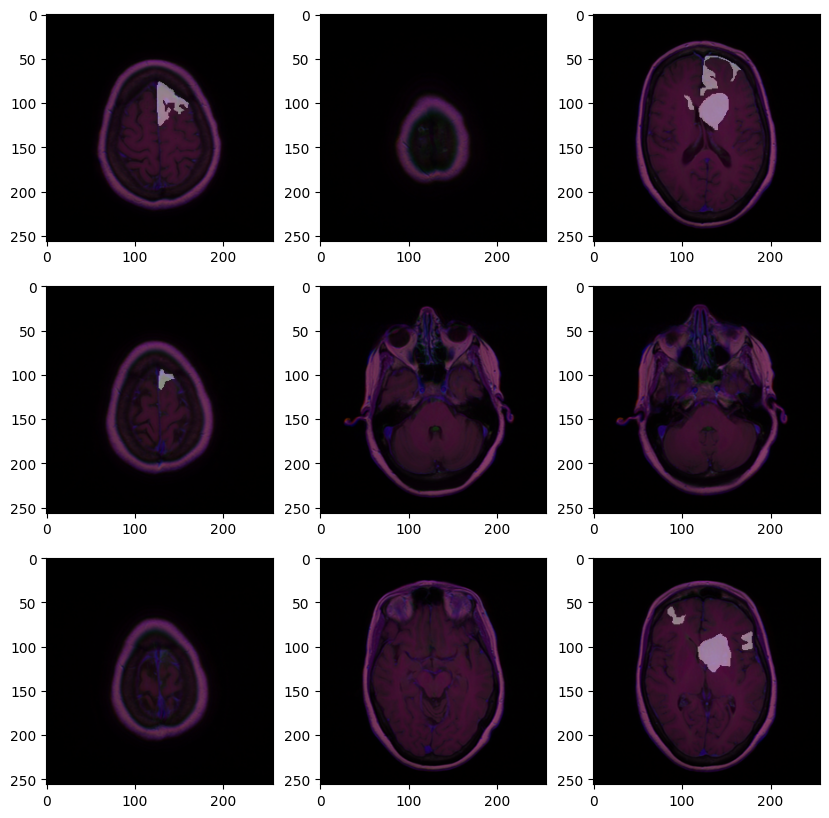

In [ ]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=images[i]
    msk_path=masks[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [ ]:
# split data n
df = pd.DataFrame(data={"image": images, 'mask' : masks})
df_train, df_test = train_test_split(df,test_size = 0.2)
print(df_train.values.shape)
print(df_test.values.shape)

(3143, 2)
(786, 2)


In [ ]:
def normalize_data(image, mask):
    image = image/255 # ảnh 8 bit
    mask = mask / 255
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0

    return (image, mask)

In [ ]:
smooth=100
import keras.backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def Tversky(y_true, y_pred, alpha=0.5, beta=0.5, smooth=100):
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    #True Positives, False Positives & False Negatives
    TP = K.sum((y_pred * y_true))
    FP = K.sum(((1-y_true) * y_pred))
    FN = K.sum((y_true * (1-y_pred)))

    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

    return Tversky

In [ ]:
def unet(input_shape=(IMG_HEIGHT,IMG_HEIGHT,3)):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    model = Model(inputs=[inputs], outputs=[conv10])
    # model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss='binary_crossentropy' , metrics=['accuracy', iou, dice_coef, precision,recall,specificity])
    return model

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256,256),
    seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_data(img, mask)
        yield (img,mask)

In [ ]:
unet_model = unet()
print(unet_model.summary())
# keras.utils.plot_model(unet_model,show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
BATCH_SIZE=2
EPOCHS=10

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
# train_generator_args = dict()
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(IMG_HEIGHT, IMG_WIDTH))

test_gener = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(IMG_HEIGHT, IMG_WIDTH))
model = unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=None,
                    validation_data = test_gener,
                    validation_steps=len(df_test) / BATCH_SIZE)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/10
1572/1571 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9873 - iou: 0.0693 - dice_coef: 0.1067 - precision: 0.3152 - recall: 0.2085 - specificity: 0.9933Found 786 validated image filenames.
Found 786 validated image filenames.
1571/1571 [==============================] - 3529s 2s/step - loss: 0.0923 - accuracy: 0.9873 - iou: 0.0693 - dice_coef: 0.1067 - precision: 0.3152 - recall: 0.2085 - specificity: 0.9933 - val_loss: 0.0396 - val_accuracy: 0.9928 - val_iou: 0.1175 - val_dice_coef: 0.1685 - val_precision: 0.3406 - val_recall: 0.2508 - val_specificity: 0.9975
Epoch 2/10
1571/1571 [==============================] - 246s 157ms/step - loss: 0.0326 - accuracy: 0.9928 - iou: 0.1557 - dice_coef: 0.2143 - precision: 0.3497 - recall: 0.2558 - specificity: 0.9981 - val_loss: 0.0303 - val_accuracy: 0.9911 - val_iou: 0.1379 - val_dice_coef: 0.1826 - val_precision: 0.2998 - val_recall

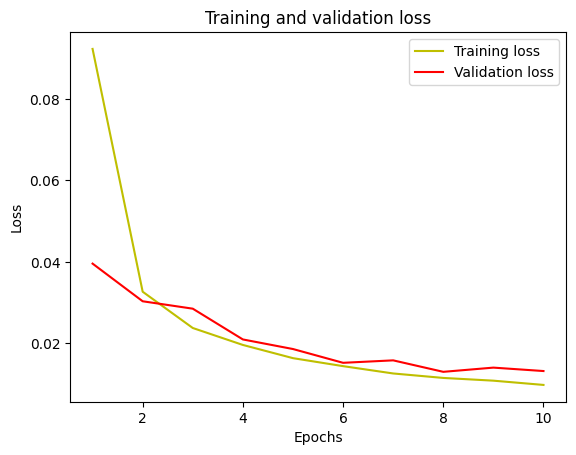

In [ ]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

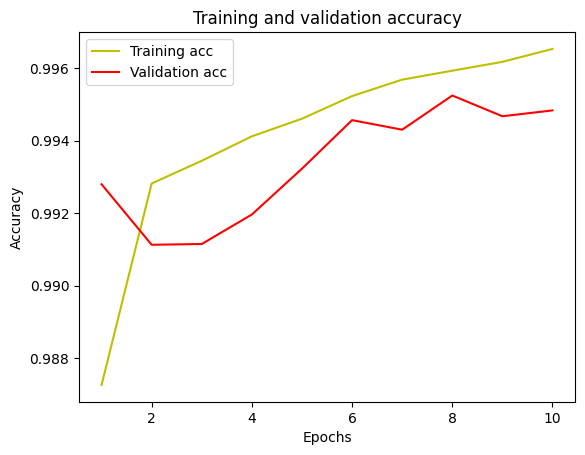

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# model.save('unet_model.h5')
model.save('/content/drive/MyDrive/DATN/unet_model.h5')

In [ ]:
# results_train = model.evaluate(train_gen, steps=len(df_train) / BATCH_SIZE)
# print ("Loss = " + str(results_train[0]))
# print ("Test Accuracy = " + str(results_train[1]))

1571/1571 [==============================] - 113s 72ms/step - loss: 0.0164 - accuracy: 0.9933 - iou: 0.5512 - dice_coef: 0.6166 - precision: 0.4092 - recall: 0.4431 - specificity: 0.9947


In [ ]:
results_test = model.evaluate(test_gener, steps=len(df_test) / BATCH_SIZE)
print ("Loss = " + str(results_test[0]))
print ("Test Accuracy = " + str(results_test[1]))

393/393 [==============================] - 19s 49ms/step - loss: 0.0143 - accuracy: 0.9943 - iou: 0.5303 - dice_coef: 0.5985 - precision: 0.4220 - recall: 0.4382 - specificity: 0.9960
Loss = 0.014291287399828434
Test Accuracy = 0.9942917227745056


In [ ]:
df.head()

,image,mask
0,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...
1,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...
2,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...
3,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...
4,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...


1/1 [==============================] - 0s 21ms/step


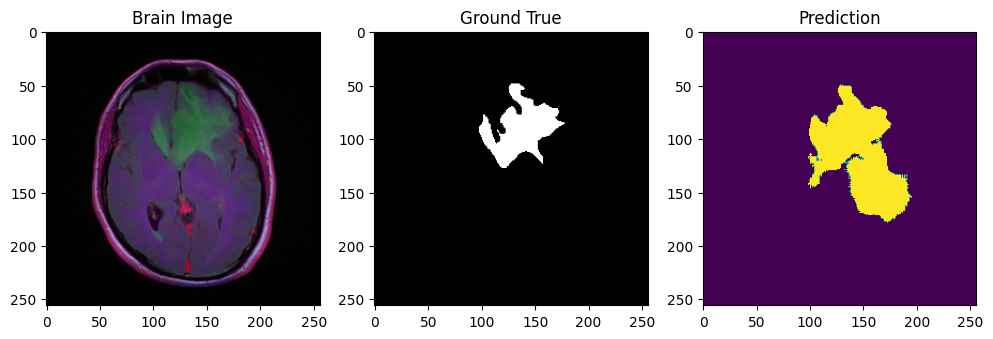

In [ ]:
import cv2

index=np.random.randint(1,len(df_test.index))
for i in range(1,2):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df['image'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(i,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Brain Image')
    plt.subplot(i,3,2)
    plt.imshow(np.squeeze(cv2.imread(df['mask'].iloc[index])))
    plt.title('Ground True')
    plt.subplot(i,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('Prediction')

In [ ]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'

df_tumor = pd.DataFrame({"image_path": images,
                   "mask_path": masks,
                  "diagnosis":[diagnosis(x) for x in masks]})
df_tumor.head()

,image_path,mask_path,diagnosis
0,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,0
1,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,1
2,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,0
3,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,1
4,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,/content/drive/MyDrive/DATN/kaggle_3m/TCGA_HT_...,1


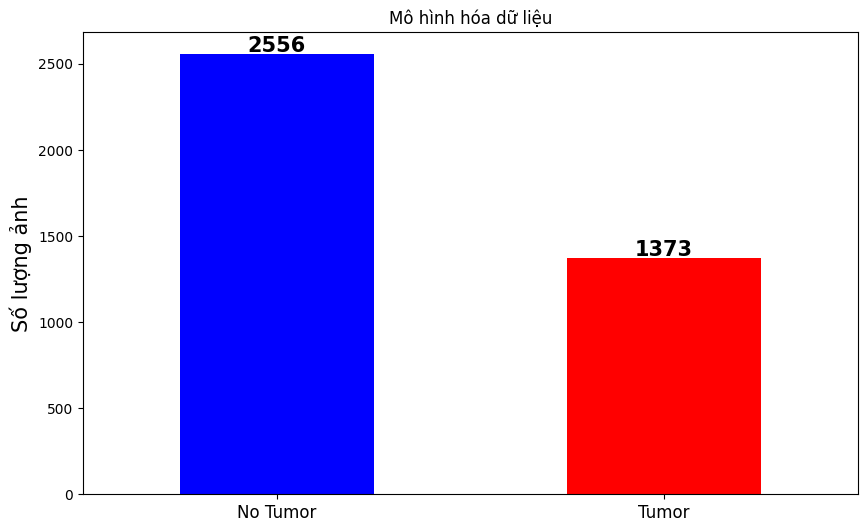

In [ ]:
ax = df_tumor['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Mô hình hóa dữ liệu')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df_tumor['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [ ]:
df_tumor_train, df_tumor_test = train_test_split(df_tumor, test_size=0.2)

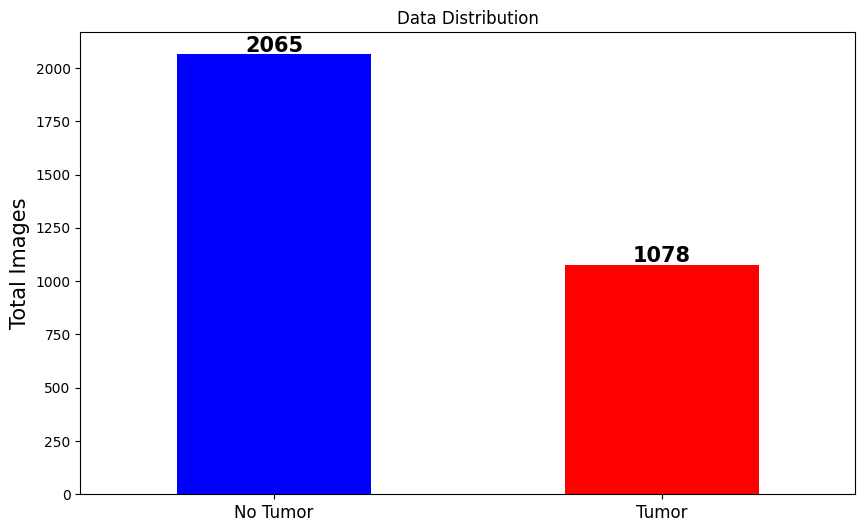

In [ ]:
ax = df_tumor_train['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Mô hình hóa dữ liệu train')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df_tumor_train['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

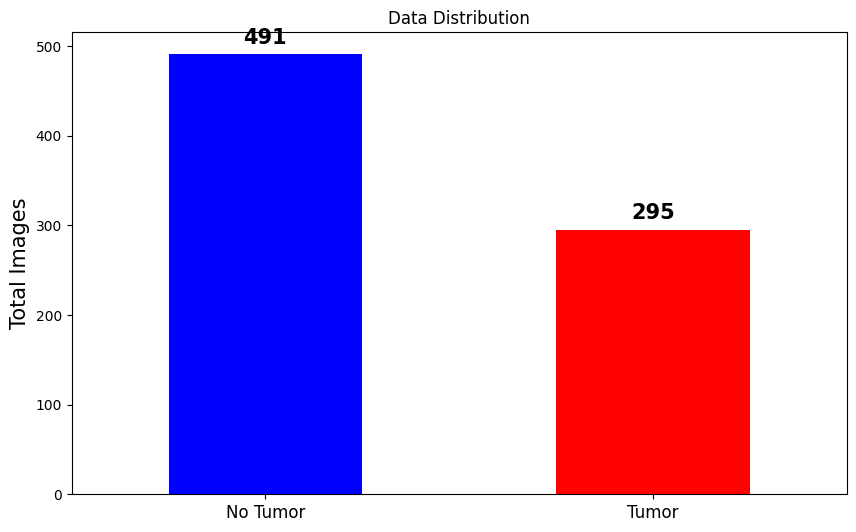

In [ ]:
ax = df_tumor_test['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Mô hình hóa dữ liệu test')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df_tumor_test['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

1/1 [==============================] - 0s 20ms/step
No Tumor


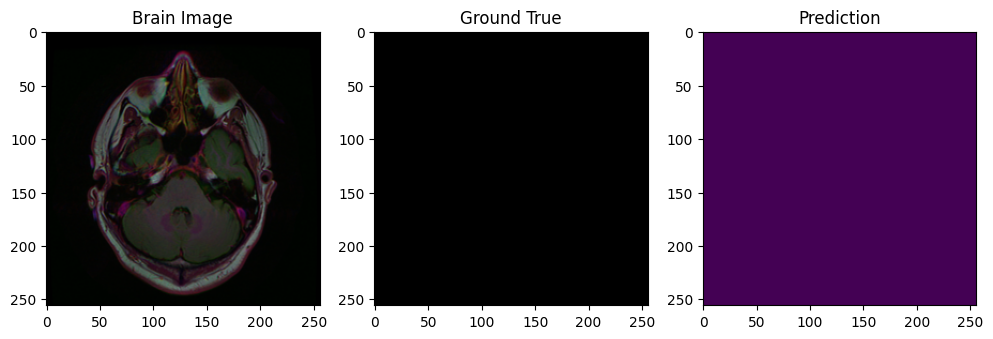

In [ ]:
index=np.random.randint(1,len(df_test.index))
for i in range(1,2):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_tumor_test['image_path'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    tumor=np.squeeze(df_tumor_test['diagnosis'].iloc[index])
    if tumor == '1':
      print("Tumor")
    else:
      print("No Tumor")

    plt.figure(figsize=(12,12))
    plt.subplot(i,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Brain Image')
    plt.subplot(i,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_tumor_test['mask_path'].iloc[index])))
    plt.title('Ground True')
    plt.subplot(i,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('Prediction')